In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [213]:
class DataSetGenerator:
            
    def pointsOnCircle(self, num_points=100, r=10, mean=0, stddev=0.1, minval=-0.1, maxval=0.1):

        # generate angles between -PI and PI
        radians = np.random.random_sample((num_points,)) * 2 * np.pi - np.pi

        # generate noises
        noises = np.clip(np.random.normal(mean, stddev, (num_points)), minval, maxval)

        pts = np.array([np.cos(radians), np.sin(radians)]) * (r + noises)

        return pts.T
    
    def pointsOnBox(self, num_points=100, x0=-10, x1=10, y0=-10, y1=10, mean=0, stddev=0.1, minval=-0.1, maxval=0.1):

        #generate points
        x_coord = np.random.uniform(low=x0, high=x1, size=num_points)
        y_coord = np.random.uniform(low=y0, high=y1, size=num_points)

        # generate noises
        noises = np.clip(np.random.normal(mean, stddev, (2,num_points)), minval, maxval)

        pts = np.array([x_coord, y_coord]) + noises

        return pts.T
    
    def pointsOnLine(self, num_points=100, x0=-10, x1=10, y0=-10, y1=10, slope=1, intercept=2, mean=0, stddev=1):
        x_coord = np.linspace(x0,x1,num_points)
        
        # generate noises
        noises = np.random.normal(mean, stddev, num_points)
        
        b = intercept + noises
        X = np.array([np.ones(num_points), x_coord])
        y = slope * x_coord + b
        return X.T, y.reshape(num_points,1)

In [214]:
class RanSac:
    def run(self, ransac_program, input_data, max_iteration=10, max_error=8.0, min_inliers_ratio=0.99):
        N = len(input_data)
        inliers = np.zeros(N, dtype=bool)
        inliers_ratio = 0
        iteration = 0
        cx = 0
        cy = 0
        r = 0
        inliers_per_run = np.zeros(N+1)
        while inliers_ratio < min_inliers_ratio and iteration < max_iteration:
            iteration = iteration + 1
            curr_inliers, curr_inliers_ratio, curr_inliers_num, curr_cx, curr_cy, curr_r = ransac_program(input_data, max_error)
            inliers_per_run[curr_inliers_num] += 1
            if curr_inliers_ratio > inliers_ratio:
                inliers = curr_inliers
                inliers_ratio = curr_inliers_ratio
                cx = curr_cx
                cy = curr_cy
                r = curr_r
        
        return inliers, inliers_ratio, cx, cy, r, inliers_per_run
        

In [215]:
def getCircle(pt1, pt2, pt3):
    x1, y1 = pt1
    x2, y2 = pt2
    x3, y3 = pt3
    c = (x1-x2)**2 + (y1-y2)**2
    a = (x2-x3)**2 + (y2-y3)**2
    b = (x3-x1)**2 + (y3-y1)**2
    s = 2*(a*b + b*c + c*a) - (a*a + b*b + c*c) 
    if s == 0.0:
        return 0.0, 0.0, 0.0
    
    cx = (a*(b+c-a)*x1 + b*(c+a-b)*x2 + c*(a+b-c)*x3) / s
    cy = (a*(b+c-a)*y1 + b*(c+a-b)*y2 + c*(a+b-c)*y3) / s 
    
    ar = a**0.5
    br = b**0.5
    cr = c**0.5 
    r = ar*br*cr / ((ar+br+cr)*(-ar+br+cr)*(ar-br+cr)*(ar+br-cr))**0.5
    return cx, cy, r
    

In [216]:
def ransac3PtsCircle(input_data, max_error=8.0):
    N = len(input_data)
    selected = np.random.randint(N,size=3)
    cx, cy, r = getCircle(input_data[selected[0],:], input_data[selected[1],:], input_data[selected[2],:])
    centroid = np.array([cx, cy])
    r_low = r-max_error
    r_high = r+max_error
    dist = np.sqrt(np.sum((input_data - centroid) ** 2, axis=1))
    inliers = np.logical_and(dist <= r_high, dist >= r_low)
    num_inliers = np.sum(inliers)
    return inliers, num_inliers / N, num_inliers, cx, cy, r
    

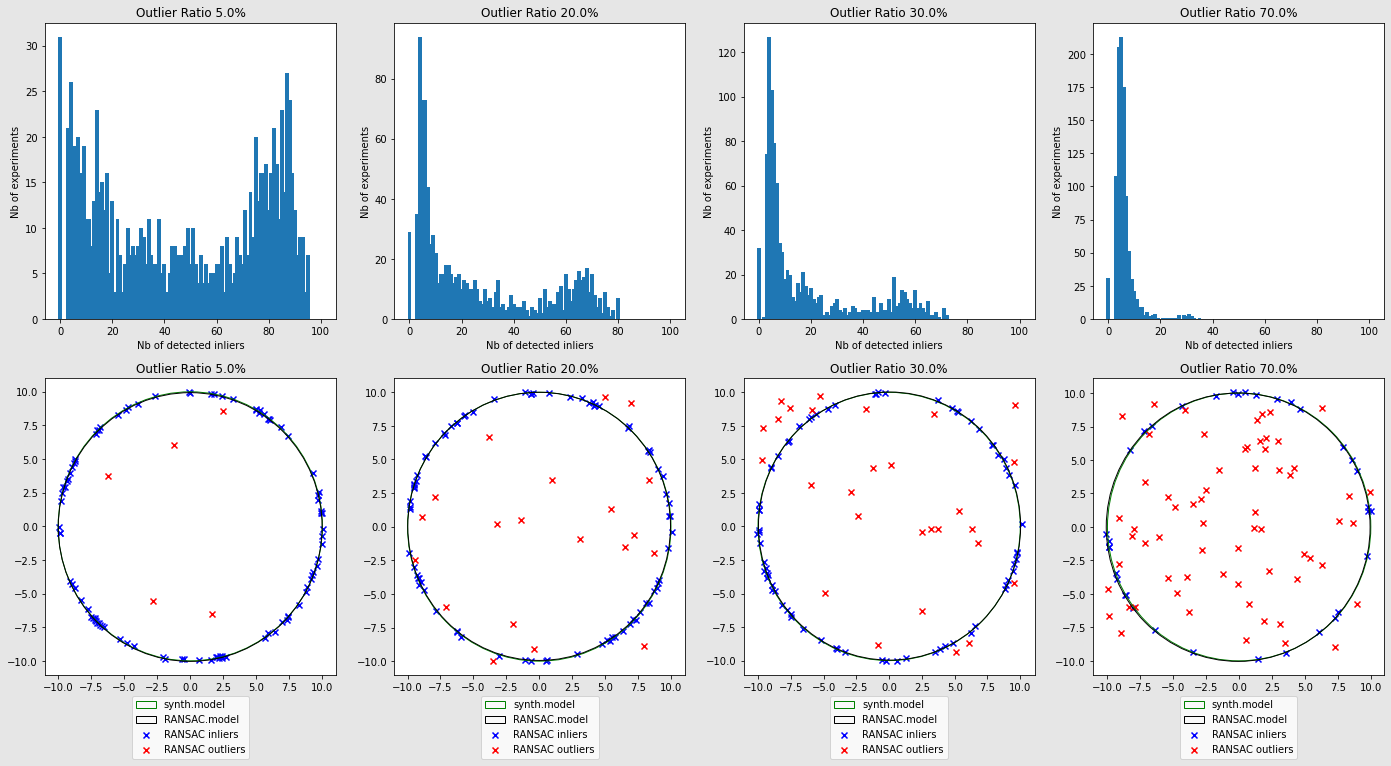

In [217]:
#Test Cases
outlier_ratios = np.array([0.05, 0.2, 0.3, 0.7])
N = 100

# Initiate classes
dsg = DataSetGenerator()
rs = RanSac()

# Initiate Plots
plt.rcParams['figure.facecolor'] = '#E6E6E6'
plt.rcParams['figure.figsize'] = (24,12)
T = len(outlier_ratios)
fig, axs = plt.subplots(2, T)
ind = np.arange(N+1)

tests_inliers = []
tests_outliers = []

for t, eps in enumerate(outlier_ratios):
    
    num_outliers = round(N * eps)
    num_inliers = N - num_outliers
    pts_i = dsg.pointsOnCircle(num_inliers)
    pts_o = dsg.pointsOnBox(num_outliers)
    input_data = np.vstack((pts_i,pts_o))
    n = 1000#np.max(100, round(np.log(0.01) / np.log(1-(1-eps)**3)))
    
    inliers, inliers_ratio, cx, cy, r, inliers_per_run = rs.run(ransac3PtsCircle, input_data, n, 0.15)

    tests_inliers.append(input_data[inliers,:])
    tests_outliers.append(input_data[np.logical_not(inliers),:])
    axs[0, t].title.set_text('Outlier Ratio ' + str(100*eps) + "%")
    axs[0, t].set_xlabel('Nb of detected inliers')
    axs[0, t].set_ylabel('Nb of experiments')
    axs[0, t].bar(ind, inliers_per_run, 1.5)
    
    axs[1, t].title.set_text('Outlier Ratio ' + str(100*eps) + "%")
    axs[1, t].scatter(tests_inliers[t][:,0], tests_inliers[t][:,1], marker='x', color="blue", label='RANSAC inliers')
    axs[1, t].scatter(tests_outliers[t][:,0], tests_outliers[t][:,1], marker='x', color="red", label='RANSAC outliers')
    circle = plt.Circle((0, 0), 10, color='green', fill=False, label='synth.model')
    circle_r = plt.Circle((cx, cy), r, color='black', fill=False, label='RANSAC.model')
    axs[1, t].add_patch(circle)
    axs[1, t].add_patch(circle_r)
    axs[1, t].legend(loc="lower center", bbox_to_anchor=(0.5, -0.3))
    

# plt.xlabel('x')
# plt.ylabel('y')
plt.show()

##############################################################################
IRLS solution

https://en.wikipedia.org/wiki/Iteratively_reweighted_least_squares

solving the weighted lienear least squares problem per iteration where $W^{t}$ is the diagonal matrix of weights:

$\hat{\beta}$ = $(X^{T}W^{t}X)^{-1}X^{T}y$

$L^{p}$ norm linear regression

At every iteration update

$w_{i}^{(t)} = |y_{i} - X_{i}\beta^{(t)}|^{p-2} $

special case p = 1
$w_{i}^{(t)} = \frac{1}{|y_{i} - X_{i}\beta^{(t)}|}$

To avoid dividing by zero, regularization $\delta$=0.0001
$w_{i}^{(t)} = \frac{1}{max\{\delta,|y_{i} - X_{i}\beta^{(t)}|\}}$

In [ ]:
def IRLS(X, y, max_iteration=10, min_delta=0.0001, min_tolerance=0.001):
    M, N = X.shape
    
    #inititalize delta, w, beta_hat
    delta = np.ones((1,M)) * min_delta
    w = np.ones(M)
    W = np.diag(w)
    beta_hat = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y) 
    
    iteration = 0
    tolerance = 2 * min_tolerance
    while iteration < max_iteration and tolerance >= min_tolerance:
        
        # prev beta
        beta_hat_prev = beta_hat
        
        # update w and W
        w_prev = np.abs(y - X @ beta_hat).T
        w = 1 / np.maximum(delta, w_prev)
        W = np.diag(w[0])
        
        # curr beta
        beta_hat = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)
        
        # difference between iterations
        tolerance = np.sum(np.abs(beta_hat - beta_hat_prev)) 
        iteration += 1
    print(iteration, tolerance)
    return beta_hat

In [ ]:
X, y = dsg.pointsOnLine(100, slope=0.3, intercept=3.5)
beta = IRLS(X, y, max_iteration=1000, min_tolerance=0.0001)
print(beta)
plt.scatter(X[:,1], y, marker='o', color="blue")
x_ = np.linspace(-10,10,1000)
y_ = beta[1]*x_+beta[0]
plt.plot(x_, y_, '-r', label='trendline')
plt.show()

In [218]:
def IRLS(X, y, max_iteration=10, min_delta=0.0001, min_tolerance=0.001):
    M, N = X.shape
    
    #inititalize delta, w, beta_hat
    delta = np.ones((1,M)) * min_delta
    w = np.ones(M)
    W = np.diag(w)
    beta_hat = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y) 
    
    iteration = 0
    tolerance = 2 * min_tolerance
    while iteration < max_iteration and tolerance >= min_tolerance:
        
        # prev beta
        beta_hat_prev = beta_hat
        
        # update w and W
        w_prev = np.abs(y - X @ beta_hat).T
        w = 1 / np.maximum(delta, w_prev)
        W = np.diag(w[0])
        
        # curr beta
        beta_hat = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ y)
        
        # difference between iterations
        tolerance = np.sum(np.abs(beta_hat - beta_hat_prev)) 
        iteration += 1
    print(iteration, tolerance)
    return beta_hat

24 4.530961290827307e-06
[[3.560152  ]
 [0.30464065]]


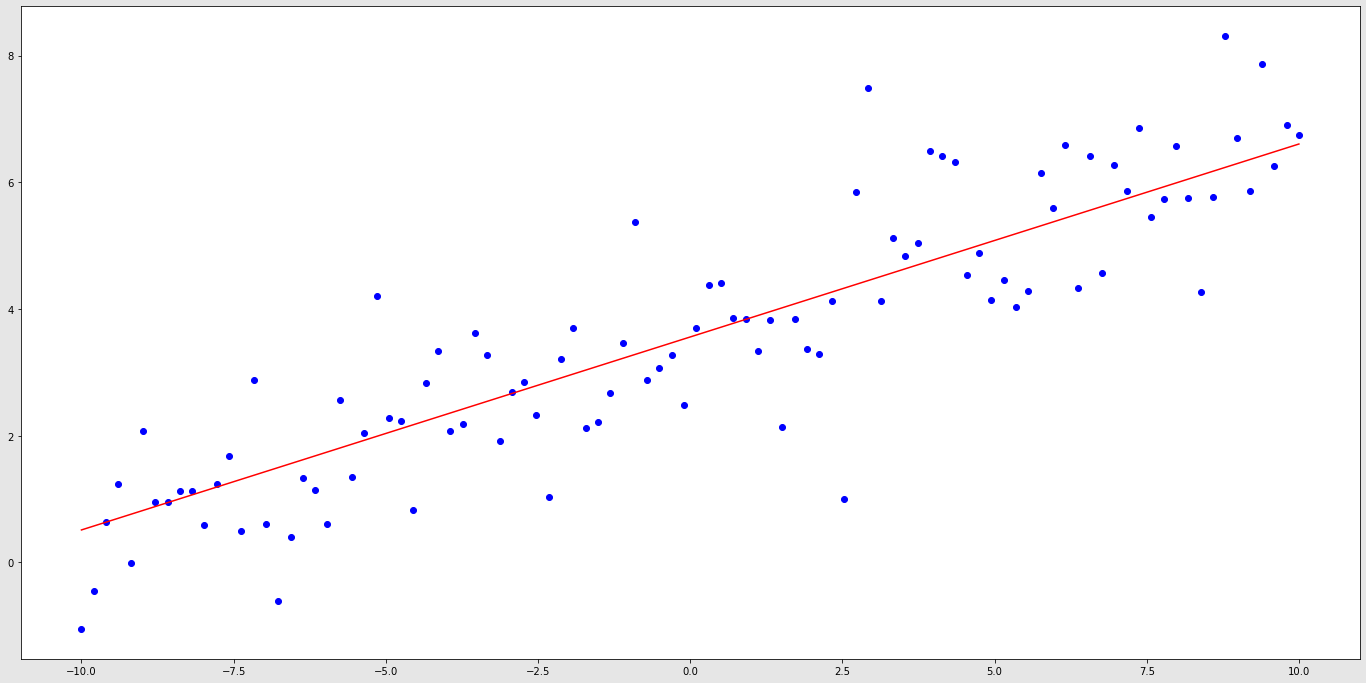

In [226]:
X, y = dsg.pointsOnLine(100, slope=0.3, intercept=3.5)
beta = IRLS(X, y, max_iteration=1000, min_tolerance=0.0001)
print(beta)
plt.scatter(X[:,1], y, marker='o', color="blue")
x_ = np.linspace(-10,10,1000)
y_ = beta[1]*x_+beta[0]
plt.plot(x_, y_, '-r', label='trendline')
plt.show()